<a href="https://colab.research.google.com/github/ggaoshen/graph_wavenet/blob/sg-final/CS224W_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS224W - Final Project**

Description goes here.

# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

# Installation

In [1]:
# Install torch geometric
import os
import torch
if 'IS_GRADESCOPE_ENV' not in os.environ:
  torch_version = str(torch.__version__)
  scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  !pip install torch-scatter -f $scatter_src
  !pip install torch-sparse -f $sparse_src
  !pip install torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git
  !pip install -U -q PyDrive

Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 34.0 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !nvcc --version
  !python -c "import torch; print(torch.version.cuda)"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
12.1


In [3]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  import torch
  print(torch.__version__)
  import torch_geometric
  print(torch_geometric.__version__)

2.1.0+cu121
2.4.0


In [4]:
# Import GraphWaveNet module
!git clone -b sg-experiment https://github.com/ggaoshen/graph_wavenet.git # NOTE: choose the right branch
%load graph_wavenet/src/graphwavenet.py
import sys
sys.path.append('graph_wavenet/src/')
from graphwavenet import GraphWaveNet
from util import masked_rmse, masked_mse, masked_mae, masked_mape, metric, temporal_dataset_split

Cloning into 'graph_wavenet'...
remote: Enumerating objects: 198, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 198 (delta 17), reused 14 (delta 8), pack-reused 152
Receiving objects: 100% (198/198), 163.30 KiB | 899.00 KiB/s, done.
Resolving deltas: 100% (104/104), done.


In [5]:
!pip install -U torch-geometric-temporal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 747.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 7.1 MB/s eta 0:00:00
  Created wheel for torch-geometric-temporal: filename=torch_geometric_temporal-0.54.0-py3-none-any.whl size=86722 sha256=91b8e0f09160c65b93a69f8fd17e6c950532f4c164038485c8181b93cf545c6d
  Stored in directory: /root/.cache/pip/wheels/9e/9b/b6/e15256e053f0cb49b1084a67a709db909d418386a231f0722c
Successfully built torch-geometric-temporal
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires pyt

In [6]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context



# Temporal Datasets

from torch_geometric_temporal.dataset import METRLADatasetLoader
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)
iterator = iter(dataset)
print("METRLA dataset from original Graph Wavenet paper: \n", next(iterator))


from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
dataset = ChickenpoxDatasetLoader().get_dataset(lags=8) # consistent with chickenpox paper
iterator = iter(dataset)
print("Chickenpox dataset: \n", next(iterator))


METRLA dataset from original Graph Wavenet paper: 
 Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])
Chickenpox dataset: 
 Data(x=[20, 8], edge_index=[2, 102], edge_attr=[102], y=[20])


In [ ]:
# Run Chickenpox Dataset

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd

# training
from tqdm import tqdm
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_path = "store/checkpoint"
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Get data

# from torch_geometric_temporal.signal import temporal_signal_split
train_ratio, val_ratio = 0.8, 0.1
# train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=train_ratio)
train_dataset, val_dataset, test_dataset = temporal_dataset_split(dataset, train_split = train_ratio, validation_split = val_ratio)
val_offset = int(dataset.snapshot_count * train_ratio) # starting index for valid set
test_offset = val_offset+int(dataset.snapshot_count * val_ratio) # starting index for valid set

def prepare_n_period_y(dataset):

    res = []
    for data in dataset:
        res.append(data.y)
    res = torch.stack(res, dim=0)

    return res

y_all = prepare_n_period_y(dataset)


# Model inputs
in_dim = dataset[0].num_node_features # 8 treat lagged inputs as node features
out_dim = 1
num_nodes = dataset[0].num_nodes # 1068
timesteps_to_predict = 10 # 10, 20, 40 week forecast horizon
epochs = 200
lrate = 0.0001
wdecay = 0.001

# early stopping parameters
patience = 10
counter = 0
best_val_loss = float('inf')


model = GraphWaveNet(
    num_nodes=num_nodes,
    in_channels=in_dim,
    out_channels=out_dim,
    out_timesteps=timesteps_to_predict,
).to(device)

# Training loop
print("start training...", flush=True)
his_loss = []
val_time = []
train_time = []
best_epoch = 0

optimizer = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=wdecay)

model.train()

training_curve_dict = {"epoch_train_loss": [], "epoch_valid_loss": []}

for epoch in tqdm(range(epochs)):
    train_loss = []
    t1 = time.time()

    for i, snapshot in enumerate(train_dataset):
        x_train = snapshot.x.reshape(-1, num_nodes, in_dim).to(device)
        if timesteps_to_predict == 1:
            y_train = snapshot.y.to(device)
        else:
            y_train = y_all[i : i + timesteps_to_predict,:].to(device)

        pred = model(x_train, snapshot.edge_index, snapshot.edge_attr).squeeze()
        loss = masked_mse(pred, y_train, 0.0) # mean squared error for loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(loss.item())

    mtrain_loss = np.mean(train_loss)
    training_curve_dict['epoch_train_loss'].append(mtrain_loss)
    print(f"training loss: {mtrain_loss}")


    t2 = time.time()
    train_time.append(t2 - t1)
    valid_loss = []

    s1 = time.time()
    for i, snapshot in enumerate(val_dataset):
        x_val = snapshot.x.reshape(-1, num_nodes, in_dim).to(device)
        if timesteps_to_predict == 1:
            y_val = snapshot.y.to(device)
        else:
            y_val = y_all[val_offset + i : val_offset + i + timesteps_to_predict,:].to(device)

        with torch.no_grad():
            pred = model(x_val, snapshot.edge_index, snapshot.edge_attr).squeeze()
        loss = masked_mse(pred, y_val, 0.0).cpu().numpy()
        valid_loss.append(loss)

    s2 = time.time()
    # log = "Epoch: {:03d}, Inference Time: {:.4f} secs"
    # print(log.format(i, (s2 - s1)))
    val_time.append(s2 - s1)

    mvalid_loss = np.mean(valid_loss)
    training_curve_dict['epoch_valid_loss'].append(mvalid_loss)

    his_loss.append(mvalid_loss)

    if np.argmin(his_loss) == len(his_loss) - 1:
        torch.save(
            model.state_dict(), save_path + "/epoch_" + str(i) + ".pth"
        )
        best_epoch = i

    log = (
        "Epoch: {:03d}, Train Loss: {:.4f}, "
        + "Valid Loss: {:.4f}, "
        + "Training Time: {:.4f}/epoch"
    )
    print(
        log.format(
            i,
            mtrain_loss,
            mvalid_loss,
            (t2 - t1),
        ),
        flush=True,
    )
print("Average Training Time: {:.4f} secs/epoch".format(np.mean(train_time)))
print("Average Inference Time: {:.4f} secs".format(np.mean(val_time)))


# eval
model.load_state_dict(
    torch.load(save_path + "/epoch_" + str(best_epoch) + ".pth")
)
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset[:-timesteps_to_predict]):

    x_test = snapshot.x.reshape(-1, num_nodes, in_dim).to(device)

    if timesteps_to_predict == 1:
        y_test = snapshot.y.to(device)
    else:
        y_test = y_all[test_offset+i : test_offset+i + timesteps_to_predict,:].to(device)


    with torch.no_grad():
        pred = model(x_test, snapshot.edge_index, snapshot.edge_attr).squeeze()
    loss += masked_mse(pred, y_test, 0.0) # mean squared error as loss

loss = loss / (i+1)
loss = loss.item()
print("Test MSE Loss: {:.4f}".format(loss))


# store training loss
df = pd.DataFrame(training_curve_dict)
df.to_csv("training_curve.csv")

from google.colab import files
files.download('training_curve.csv')

# plot training and validation loss
df.plot()


start training...


  0%|          | 0/200 [00:00<?, ?it/s]

training loss: 0.9670065093149499
Epoch: 050, Train Loss: 0.9670, Valid Loss: 0.8954, Training Time: 21.9304/epoch


  0%|          | 1/200 [00:23<1:18:56, 23.80s/it]

training loss: 0.9522934666039741
Epoch: 050, Train Loss: 0.9523, Valid Loss: 0.8916, Training Time: 22.5046/epoch


  1%|          | 2/200 [00:47<1:18:40, 23.84s/it]

training loss: 0.9464662316823151
Epoch: 050, Train Loss: 0.9465, Valid Loss: 0.8886, Training Time: 23.1274/epoch


  2%|▏         | 3/200 [01:12<1:19:15, 24.14s/it]

training loss: 0.9428570809887676
Epoch: 050, Train Loss: 0.9429, Valid Loss: 0.8875, Training Time: 23.0285/epoch


  2%|▏         | 4/200 [01:36<1:19:11, 24.24s/it]

training loss: 0.9402506274012167
Epoch: 050, Train Loss: 0.9403, Valid Loss: 0.8869, Training Time: 22.9700/epoch


  2%|▎         | 5/200 [02:00<1:18:55, 24.28s/it]

training loss: 0.9385926656152417
Epoch: 050, Train Loss: 0.9386, Valid Loss: 0.8873, Training Time: 22.2180/epoch


  3%|▎         | 6/200 [02:25<1:18:19, 24.23s/it]

training loss: 0.9369149134108206
Epoch: 050, Train Loss: 0.9369, Valid Loss: 0.8868, Training Time: 22.4944/epoch


  4%|▎         | 7/200 [02:48<1:17:33, 24.11s/it]

training loss: 0.9358525120721357
Epoch: 050, Train Loss: 0.9359, Valid Loss: 0.8856, Training Time: 23.3982/epoch


  4%|▍         | 8/200 [03:13<1:17:53, 24.34s/it]

training loss: 0.9343417786243485
Epoch: 050, Train Loss: 0.9343, Valid Loss: 0.8857, Training Time: 23.0488/epoch


  4%|▍         | 9/200 [03:38<1:17:32, 24.36s/it]

training loss: 0.9336091564423064
Epoch: 050, Train Loss: 0.9336, Valid Loss: 0.8859, Training Time: 23.0022/epoch


  5%|▌         | 10/200 [04:02<1:17:08, 24.36s/it]

training loss: 0.9326754866077043
Epoch: 050, Train Loss: 0.9327, Valid Loss: 0.8852, Training Time: 22.5446/epoch


  6%|▌         | 11/200 [04:26<1:16:46, 24.37s/it]

training loss: 0.9323383237575976
Epoch: 050, Train Loss: 0.9323, Valid Loss: 0.8856, Training Time: 22.2490/epoch


  6%|▌         | 12/200 [04:50<1:15:54, 24.22s/it]

training loss: 0.9313087186480804
Epoch: 050, Train Loss: 0.9313, Valid Loss: 0.8861, Training Time: 23.0610/epoch


  6%|▋         | 13/200 [05:15<1:15:43, 24.29s/it]

training loss: 0.9311377667435785
Epoch: 050, Train Loss: 0.9311, Valid Loss: 0.8858, Training Time: 23.2362/epoch


  7%|▋         | 14/200 [05:39<1:15:36, 24.39s/it]

training loss: 0.9304937975254001
Epoch: 050, Train Loss: 0.9305, Valid Loss: 0.8850, Training Time: 23.4287/epoch


  8%|▊         | 15/200 [06:04<1:15:37, 24.53s/it]

training loss: 0.9302871889548331
Epoch: 050, Train Loss: 0.9303, Valid Loss: 0.8853, Training Time: 24.0991/epoch


  8%|▊         | 16/200 [06:30<1:16:05, 24.81s/it]

training loss: 0.9300256919252073
Epoch: 050, Train Loss: 0.9300, Valid Loss: 0.8848, Training Time: 24.1099/epoch


  8%|▊         | 17/200 [06:55<1:16:19, 25.03s/it]

training loss: 0.9297102421931014
Epoch: 050, Train Loss: 0.9297, Valid Loss: 0.8855, Training Time: 22.7462/epoch


  9%|▉         | 18/200 [07:20<1:15:36, 24.93s/it]

training loss: 0.9290758399883422
Epoch: 050, Train Loss: 0.9291, Valid Loss: 0.8843, Training Time: 24.1810/epoch


 10%|▉         | 19/200 [07:46<1:16:20, 25.30s/it]

training loss: 0.9289130981420962
Epoch: 050, Train Loss: 0.9289, Valid Loss: 0.8841, Training Time: 23.0810/epoch


 10%|█         | 20/200 [08:11<1:15:10, 25.06s/it]

training loss: 0.9284806712144396
Epoch: 050, Train Loss: 0.9285, Valid Loss: 0.8852, Training Time: 24.5435/epoch


 10%|█         | 21/200 [08:37<1:15:36, 25.34s/it]

training loss: 0.9285453596674814
Epoch: 050, Train Loss: 0.9285, Valid Loss: 0.8854, Training Time: 23.8259/epoch


 11%|█         | 22/200 [09:02<1:15:05, 25.31s/it]

training loss: 0.9281094570712345
Epoch: 050, Train Loss: 0.9281, Valid Loss: 0.8841, Training Time: 23.9434/epoch


 12%|█▏        | 23/200 [09:27<1:14:42, 25.33s/it]

training loss: 0.9276706852563997
Epoch: 050, Train Loss: 0.9277, Valid Loss: 0.8849, Training Time: 24.2507/epoch


 12%|█▏        | 24/200 [09:53<1:14:38, 25.44s/it]

training loss: 0.9274088007511525
Epoch: 050, Train Loss: 0.9274, Valid Loss: 0.8845, Training Time: 24.2239/epoch


 12%|█▎        | 25/200 [10:19<1:14:24, 25.51s/it]

training loss: 0.9273088980920431
Epoch: 050, Train Loss: 0.9273, Valid Loss: 0.8840, Training Time: 24.4087/epoch


 13%|█▎        | 26/200 [10:44<1:14:18, 25.63s/it]

training loss: 0.9270677090917782
Epoch: 050, Train Loss: 0.9271, Valid Loss: 0.8846, Training Time: 24.5924/epoch


 14%|█▎        | 27/200 [11:10<1:14:14, 25.75s/it]

training loss: 0.9270709987184623
Epoch: 050, Train Loss: 0.9271, Valid Loss: 0.8849, Training Time: 24.5881/epoch


 14%|█▍        | 28/200 [11:37<1:14:04, 25.84s/it]

training loss: 0.9264936023051056
Epoch: 050, Train Loss: 0.9265, Valid Loss: 0.8848, Training Time: 24.4191/epoch


 14%|█▍        | 29/200 [12:03<1:13:54, 25.93s/it]

training loss: 0.9266474665301602
Epoch: 050, Train Loss: 0.9266, Valid Loss: 0.8843, Training Time: 23.8836/epoch


 15%|█▌        | 30/200 [12:29<1:13:28, 25.93s/it]

training loss: 0.9260685529787003
Epoch: 050, Train Loss: 0.9261, Valid Loss: 0.8848, Training Time: 23.5086/epoch


 16%|█▌        | 31/200 [12:54<1:12:42, 25.82s/it]

training loss: 0.9259826513688739
Epoch: 050, Train Loss: 0.9260, Valid Loss: 0.8844, Training Time: 23.7232/epoch


 16%|█▌        | 32/200 [13:20<1:11:59, 25.71s/it]

training loss: 0.9256197786367522
Epoch: 050, Train Loss: 0.9256, Valid Loss: 0.8849, Training Time: 23.8873/epoch


 16%|█▋        | 33/200 [13:45<1:11:15, 25.60s/it]

training loss: 0.9252732465634259
Epoch: 050, Train Loss: 0.9253, Valid Loss: 0.8847, Training Time: 24.2314/epoch


 17%|█▋        | 34/200 [14:11<1:10:51, 25.61s/it]

training loss: 0.9252499033765095
Epoch: 050, Train Loss: 0.9252, Valid Loss: 0.8846, Training Time: 24.1181/epoch


 18%|█▊        | 35/200 [14:36<1:10:24, 25.60s/it]

training loss: 0.9249630089122348
Epoch: 050, Train Loss: 0.9250, Valid Loss: 0.8839, Training Time: 24.0817/epoch


 18%|█▊        | 36/200 [15:02<1:09:54, 25.58s/it]

training loss: 0.9245316759842198
Epoch: 050, Train Loss: 0.9245, Valid Loss: 0.8850, Training Time: 23.9703/epoch


 18%|█▊        | 37/200 [15:27<1:09:20, 25.52s/it]

training loss: 0.9242158021232704
Epoch: 050, Train Loss: 0.9242, Valid Loss: 0.8840, Training Time: 25.4326/epoch


 19%|█▉        | 38/200 [15:54<1:09:59, 25.92s/it]

training loss: 0.9240525687340556
Epoch: 050, Train Loss: 0.9241, Valid Loss: 0.8852, Training Time: 23.8846/epoch


 20%|█▉        | 39/200 [16:19<1:09:03, 25.73s/it]

training loss: 0.9236472274562935
Epoch: 050, Train Loss: 0.9236, Valid Loss: 0.8849, Training Time: 23.9585/epoch


 20%|██        | 40/200 [16:45<1:08:23, 25.64s/it]

training loss: 0.9232124969772086
Epoch: 050, Train Loss: 0.9232, Valid Loss: 0.8843, Training Time: 23.5687/epoch


 20%|██        | 41/200 [17:10<1:07:53, 25.62s/it]

training loss: 0.9231581731676692
Epoch: 050, Train Loss: 0.9232, Valid Loss: 0.8843, Training Time: 23.1892/epoch


 21%|██        | 42/200 [17:36<1:07:10, 25.51s/it]

training loss: 0.9230289770517407
Epoch: 050, Train Loss: 0.9230, Valid Loss: 0.8845, Training Time: 23.5088/epoch


 22%|██▏       | 43/200 [18:01<1:06:28, 25.40s/it]

training loss: 0.9227618476239646
Epoch: 050, Train Loss: 0.9228, Valid Loss: 0.8853, Training Time: 24.3075/epoch


 22%|██▏       | 44/200 [18:26<1:06:20, 25.52s/it]

training loss: 0.9225805415794617
Epoch: 050, Train Loss: 0.9226, Valid Loss: 0.8850, Training Time: 24.9231/epoch


 22%|██▎       | 45/200 [18:53<1:06:35, 25.78s/it]

training loss: 0.9219271725861401
Epoch: 050, Train Loss: 0.9219, Valid Loss: 0.8840, Training Time: 24.9674/epoch


 23%|██▎       | 46/200 [19:19<1:06:41, 25.99s/it]

training loss: 0.9218691996957471
Epoch: 050, Train Loss: 0.9219, Valid Loss: 0.8851, Training Time: 24.9854/epoch


 24%|██▎       | 47/200 [19:46<1:06:40, 26.14s/it]

training loss: 0.9212864077036701
Epoch: 050, Train Loss: 0.9213, Valid Loss: 0.8845, Training Time: 24.8859/epoch


 24%|██▍       | 48/200 [20:12<1:06:24, 26.21s/it]

training loss: 0.9212923064555337
Epoch: 050, Train Loss: 0.9213, Valid Loss: 0.8850, Training Time: 24.9057/epoch


 24%|██▍       | 49/200 [20:39<1:06:05, 26.26s/it]

training loss: 0.9209264034541642
Epoch: 050, Train Loss: 0.9209, Valid Loss: 0.8845, Training Time: 25.0585/epoch


 25%|██▌       | 50/200 [21:05<1:05:52, 26.35s/it]

training loss: 0.9203825540431753
Epoch: 050, Train Loss: 0.9204, Valid Loss: 0.8850, Training Time: 25.0983/epoch


 26%|██▌       | 51/200 [21:32<1:05:37, 26.42s/it]

training loss: 0.920221476079669
Epoch: 050, Train Loss: 0.9202, Valid Loss: 0.8849, Training Time: 24.8077/epoch


 26%|██▌       | 52/200 [21:58<1:05:04, 26.38s/it]

training loss: 0.9194709126814836
Epoch: 050, Train Loss: 0.9195, Valid Loss: 0.8847, Training Time: 25.0323/epoch


 26%|██▋       | 53/200 [22:25<1:04:47, 26.45s/it]

training loss: 0.9189263942765027
Epoch: 050, Train Loss: 0.9189, Valid Loss: 0.8846, Training Time: 25.3852/epoch


 27%|██▋       | 54/200 [22:52<1:04:42, 26.59s/it]

training loss: 0.9191499400793053
Epoch: 050, Train Loss: 0.9191, Valid Loss: 0.8852, Training Time: 25.8162/epoch


 28%|██▊       | 55/200 [23:19<1:04:50, 26.83s/it]

training loss: 0.9188103523786838
Epoch: 050, Train Loss: 0.9188, Valid Loss: 0.8853, Training Time: 27.6523/epoch


 28%|██▊       | 56/200 [23:48<1:06:07, 27.55s/it]

training loss: 0.9184192833149942
Epoch: 050, Train Loss: 0.9184, Valid Loss: 0.8854, Training Time: 26.3706/epoch


 28%|██▊       | 57/200 [24:16<1:06:09, 27.76s/it]

training loss: 0.917685338882048
Epoch: 050, Train Loss: 0.9177, Valid Loss: 0.8848, Training Time: 26.6339/epoch


 29%|██▉       | 58/200 [24:45<1:06:30, 28.11s/it]

training loss: 0.9174711367206239
Epoch: 050, Train Loss: 0.9175, Valid Loss: 0.8855, Training Time: 27.3098/epoch


 30%|██▉       | 59/200 [25:14<1:06:38, 28.36s/it]

training loss: 0.9172390758673229
Epoch: 050, Train Loss: 0.9172, Valid Loss: 0.8859, Training Time: 28.0409/epoch


 30%|███       | 60/200 [25:44<1:07:09, 28.78s/it]

training loss: 0.9167082078118877
Epoch: 050, Train Loss: 0.9167, Valid Loss: 0.8853, Training Time: 28.7710/epoch


 30%|███       | 61/200 [26:14<1:07:49, 29.28s/it]

training loss: 0.9162862600258938
Epoch: 050, Train Loss: 0.9163, Valid Loss: 0.8866, Training Time: 29.1513/epoch


 31%|███       | 62/200 [26:46<1:08:50, 29.93s/it]

training loss: 0.9157822207933882
Epoch: 050, Train Loss: 0.9158, Valid Loss: 0.8857, Training Time: 27.7690/epoch


 32%|███▏      | 63/200 [27:15<1:08:02, 29.80s/it]

training loss: 0.9150789292438365
Epoch: 050, Train Loss: 0.9151, Valid Loss: 0.8855, Training Time: 27.7539/epoch


 32%|███▏      | 64/200 [27:45<1:07:18, 29.69s/it]

training loss: 0.9148465527585004
Epoch: 050, Train Loss: 0.9148, Valid Loss: 0.8870, Training Time: 27.5547/epoch


 32%|███▎      | 65/200 [28:14<1:06:32, 29.57s/it]

training loss: 0.9146894752161532
Epoch: 050, Train Loss: 0.9147, Valid Loss: 0.8857, Training Time: 28.0212/epoch


 33%|███▎      | 66/200 [28:44<1:06:32, 29.80s/it]

training loss: 0.9145076616008471
Epoch: 050, Train Loss: 0.9145, Valid Loss: 0.8849, Training Time: 27.8432/epoch


 34%|███▎      | 67/200 [29:14<1:05:54, 29.73s/it]

training loss: 0.9137134281009799
Epoch: 050, Train Loss: 0.9137, Valid Loss: 0.8868, Training Time: 27.9562/epoch


 34%|███▍      | 68/200 [29:44<1:05:23, 29.72s/it]

training loss: 0.9131776633876852
Epoch: 050, Train Loss: 0.9132, Valid Loss: 0.8860, Training Time: 28.2836/epoch


 34%|███▍      | 69/200 [30:14<1:05:09, 29.84s/it]

training loss: 0.9127949630614461
Epoch: 050, Train Loss: 0.9128, Valid Loss: 0.8863, Training Time: 28.5336/epoch


 35%|███▌      | 70/200 [30:45<1:05:19, 30.15s/it]

training loss: 0.9120784447233125
Epoch: 050, Train Loss: 0.9121, Valid Loss: 0.8873, Training Time: 29.3123/epoch


 36%|███▌      | 71/200 [31:16<1:05:27, 30.44s/it]

training loss: 0.9113171549105062
Epoch: 050, Train Loss: 0.9113, Valid Loss: 0.8874, Training Time: 28.8612/epoch


 36%|███▌      | 72/200 [31:47<1:05:23, 30.65s/it]

training loss: 0.9105478680715329
Epoch: 050, Train Loss: 0.9105, Valid Loss: 0.8877, Training Time: 30.5647/epoch


 36%|███▋      | 73/200 [32:20<1:06:25, 31.38s/it]

training loss: 0.9105236888022684
Epoch: 050, Train Loss: 0.9105, Valid Loss: 0.8872, Training Time: 29.2931/epoch


 37%|███▋      | 74/200 [32:51<1:05:44, 31.30s/it]

training loss: 0.9101536249196748
Epoch: 050, Train Loss: 0.9102, Valid Loss: 0.8868, Training Time: 29.5203/epoch


 38%|███▊      | 75/200 [33:23<1:05:15, 31.32s/it]

training loss: 0.9090362270975986
Epoch: 050, Train Loss: 0.9090, Valid Loss: 0.8877, Training Time: 30.4570/epoch


 38%|███▊      | 76/200 [33:55<1:05:29, 31.69s/it]

training loss: 0.9088186326686566
Epoch: 050, Train Loss: 0.9088, Valid Loss: 0.8877, Training Time: 30.1767/epoch


 38%|███▊      | 77/200 [34:27<1:05:11, 31.80s/it]

training loss: 0.9077426460730593
Epoch: 050, Train Loss: 0.9077, Valid Loss: 0.8891, Training Time: 30.1323/epoch


 39%|███▉      | 78/200 [35:00<1:05:14, 32.08s/it]

training loss: 0.9076576618068829
Epoch: 050, Train Loss: 0.9077, Valid Loss: 0.8882, Training Time: 29.5433/epoch


 40%|███▉      | 79/200 [35:31<1:04:20, 31.90s/it]

training loss: 0.9071878141246554
Epoch: 050, Train Loss: 0.9072, Valid Loss: 0.8881, Training Time: 30.3231/epoch


 40%|████      | 80/200 [36:04<1:04:09, 32.08s/it]

training loss: 0.9064514815807343
Epoch: 050, Train Loss: 0.9065, Valid Loss: 0.8885, Training Time: 31.6268/epoch


 40%|████      | 81/200 [36:38<1:04:32, 32.54s/it]

training loss: 0.9056317127105303
Epoch: 050, Train Loss: 0.9056, Valid Loss: 0.8895, Training Time: 30.9827/epoch


 41%|████      | 82/200 [37:11<1:04:17, 32.69s/it]

training loss: 0.9050020559622747
Epoch: 050, Train Loss: 0.9050, Valid Loss: 0.8904, Training Time: 31.6082/epoch


 42%|████▏     | 83/200 [37:44<1:04:19, 32.98s/it]

training loss: 0.9039967023744816
Epoch: 050, Train Loss: 0.9040, Valid Loss: 0.8905, Training Time: 30.9201/epoch


 42%|████▏     | 84/200 [38:17<1:03:43, 32.96s/it]

training loss: 0.9037549219980109
Epoch: 050, Train Loss: 0.9038, Valid Loss: 0.8903, Training Time: 31.8087/epoch


 42%|████▎     | 85/200 [38:51<1:03:37, 33.20s/it]

training loss: 0.9025855546953475
Epoch: 050, Train Loss: 0.9026, Valid Loss: 0.8916, Training Time: 31.1420/epoch


 43%|████▎     | 86/200 [39:24<1:03:06, 33.21s/it]

training loss: 0.9019591143491065
Epoch: 050, Train Loss: 0.9020, Valid Loss: 0.8919, Training Time: 32.7351/epoch


 44%|████▎     | 87/200 [39:59<1:03:25, 33.68s/it]

training loss: 0.901170545757362
Epoch: 050, Train Loss: 0.9012, Valid Loss: 0.8918, Training Time: 33.9612/epoch


 44%|████▍     | 88/200 [40:36<1:04:33, 34.58s/it]

training loss: 0.9002490843759804
Epoch: 050, Train Loss: 0.9002, Valid Loss: 0.8922, Training Time: 33.7801/epoch


 44%|████▍     | 89/200 [41:12<1:04:46, 35.02s/it]

training loss: 0.8994482591430225
Epoch: 050, Train Loss: 0.8994, Valid Loss: 0.8928, Training Time: 34.8472/epoch


 45%|████▌     | 90/200 [41:49<1:05:18, 35.63s/it]

training loss: 0.8985328296517453
Epoch: 050, Train Loss: 0.8985, Valid Loss: 0.8935, Training Time: 34.2978/epoch


 46%|████▌     | 91/200 [42:25<1:05:11, 35.89s/it]

training loss: 0.8978278331231416
Epoch: 050, Train Loss: 0.8978, Valid Loss: 0.8933, Training Time: 34.7635/epoch


 46%|████▌     | 92/200 [43:03<1:05:27, 36.37s/it]

training loss: 0.8969870948119134
Epoch: 050, Train Loss: 0.8970, Valid Loss: 0.8946, Training Time: 34.2446/epoch


 46%|████▋     | 93/200 [43:39<1:05:02, 36.47s/it]

training loss: 0.8962651408027585
Epoch: 050, Train Loss: 0.8963, Valid Loss: 0.8948, Training Time: 34.8765/epoch


 47%|████▋     | 94/200 [44:16<1:04:47, 36.67s/it]

training loss: 0.8950299473070517
Epoch: 050, Train Loss: 0.8950, Valid Loss: 0.8962, Training Time: 35.2278/epoch


 48%|████▊     | 95/200 [44:54<1:04:34, 36.90s/it]

training loss: 0.8950148836005388
Epoch: 050, Train Loss: 0.8950, Valid Loss: 0.8967, Training Time: 34.9292/epoch


 48%|████▊     | 96/200 [45:31<1:04:04, 36.97s/it]

training loss: 0.893819290844769
Epoch: 050, Train Loss: 0.8938, Valid Loss: 0.8961, Training Time: 34.9049/epoch


 48%|████▊     | 97/200 [46:09<1:03:49, 37.18s/it]

training loss: 0.8925346088663834
Epoch: 050, Train Loss: 0.8925, Valid Loss: 0.8971, Training Time: 34.5353/epoch


 49%|████▉     | 98/200 [46:46<1:03:05, 37.11s/it]

training loss: 0.8918639776137908
Epoch: 050, Train Loss: 0.8919, Valid Loss: 0.8967, Training Time: 35.0436/epoch


 50%|████▉     | 99/200 [47:23<1:02:29, 37.12s/it]

training loss: 0.8910232414786772
Epoch: 050, Train Loss: 0.8910, Valid Loss: 0.8982, Training Time: 34.8499/epoch


 50%|█████     | 100/200 [48:00<1:01:47, 37.08s/it]

training loss: 0.8897805037885541
Epoch: 050, Train Loss: 0.8898, Valid Loss: 0.8991, Training Time: 36.7957/epoch


 50%|█████     | 101/200 [48:39<1:02:07, 37.65s/it]

training loss: 0.8890123381347554
Epoch: 050, Train Loss: 0.8890, Valid Loss: 0.9000, Training Time: 35.1720/epoch


 51%|█████     | 102/200 [49:17<1:01:37, 37.73s/it]

training loss: 0.8876130926082048
Epoch: 050, Train Loss: 0.8876, Valid Loss: 0.9002, Training Time: 34.9329/epoch


 52%|█████▏    | 103/200 [49:54<1:00:56, 37.70s/it]

training loss: 0.8862048437046569
Epoch: 050, Train Loss: 0.8862, Valid Loss: 0.9002, Training Time: 34.7178/epoch


 52%|█████▏    | 104/200 [50:31<59:56, 37.47s/it]  

training loss: 0.8862913889446999
Epoch: 050, Train Loss: 0.8863, Valid Loss: 0.9022, Training Time: 35.1683/epoch


 52%|█████▎    | 105/200 [51:09<59:15, 37.42s/it]

training loss: 0.8849975458187301
Epoch: 050, Train Loss: 0.8850, Valid Loss: 0.9029, Training Time: 34.3315/epoch


 53%|█████▎    | 106/200 [51:45<58:13, 37.16s/it]

training loss: 0.8841938962342172
Epoch: 050, Train Loss: 0.8842, Valid Loss: 0.9022, Training Time: 34.0075/epoch


 54%|█████▎    | 107/200 [52:22<57:30, 37.10s/it]

training loss: 0.8827941016634789
Epoch: 050, Train Loss: 0.8828, Valid Loss: 0.9036, Training Time: 34.3587/epoch


 54%|█████▍    | 108/200 [52:59<56:37, 36.93s/it]

In [9]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [10]:
# Reset GPU RAM if GPU out of memory

# !pip install numba

# from numba import cuda

# cuda.select_device(0) # choosing second GPU

# cuda.close()

In [1]:
import pandas as pd

<Axes: >

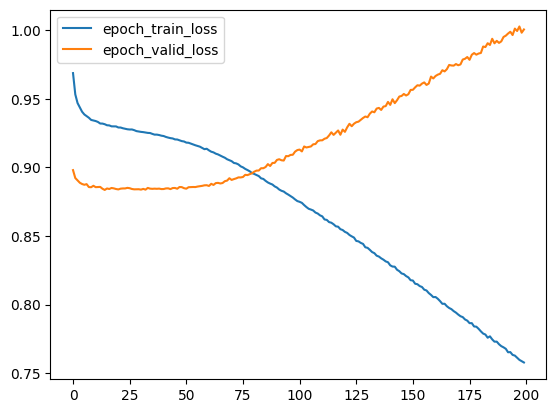

In [5]:
df = pd.read_csv("/content/training_curve_200epoch_overfit.csv", index_col=0)
df.plot()